In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from chemprop.cli import train, predict
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Loading the dataset.

In [6]:
df = pd.read_csv('../ConformalPrediction/dataset.csv')

Filtering for the "Caenorhabditis elegans" species.

In [7]:
df = df[df["species"] == "Caenorhabditis elegans"].reset_index(drop=True)

In [12]:
# Step 1: Remove rows with missing values in target column
df = df.dropna(subset=['avg_lifespan_change_percent'])

# Step 2: Find best-performing dose per compound-species pair
idx = df.groupby(['compound_name', 'species'])['avg_lifespan_change_percent'].idxmax()
df = df.loc[idx].reset_index(drop=True)

# Step 3: Now keep just one row per compound (e.g., best across all species)
df = df.sort_values('avg_lifespan_change_percent', ascending=False)
df = df.drop_duplicates(subset='compound_name').reset_index(drop=True)

Removes rows with missing values in the target column.

In [13]:
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import ssl

Configure SSL settings to avoid connection issues when retrieving SMILES data from PubChem.

In [14]:
ssl._create_default_https_context = ssl._create_unverified_context

Uses PubChem to fetch SMILES for each compound.

In [15]:
def get_smiles_from_pubchem(compound_name):
    """Fetch canonical SMILES for a compound name from PubChem."""
    try:
        compound = pcp.get_compounds(compound_name, 'name')
        if compound:
            return compound[0].canonical_smiles
    except Exception as e:
        print(f"Error fetching SMILES for {compound_name}: {e}")
    return None

Fetch SMILES strings for each compound. Remove any rows where SMILES couldn't be found.

In [16]:
df['smiles'] = df['compound_name'].apply(get_smiles_from_pubchem)
df = df.dropna(subset=['smiles'])  # Drop rows where SMILES is not available

Prepare the final dataset for Chemprop, containing only SMILES and target values, and save it as lifespan_data.csv.

In [17]:
chemprop_data = df[['smiles', 'avg_lifespan_change_percent']]
chemprop_data.to_csv('lifespan_data.csv', index=False)

Split data into training (80%) and testing (20%) datasets, clearly saving each separately.

In [18]:
train_df, test_df = train_test_split(chemprop_data, test_size=0.2, random_state=42)
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

Train a Chemprop regression model using your training data. The trained model is saved in the model_checkpoint directory.

In [ ]:
!chemprop train --data-path train_data.csv \
               --task-type regression \
               --output-dir ./model_checkpoint \
               --smiles-columns smiles \
               --target-columns avg_lifespan_change_percent \
               --split-type random \
               --data-seed 0


Use the trained Chemprop model to predict lifespan changes for compounds in your test dataset. Predictions are saved to predictions.csv.

In [20]:
!chemprop predict \
    --test-path test_data.csv \
    --model-paths ./model_checkpoint/model_0/best.pt \
    --preds-path predictions.csv \
    --smiles-columns smiles


2025-04-10T22:53:23 - INFO:chemprop.cli.main - Running in mode 'predict' with args: {'smiles_columns': ['smiles'], 'reaction_columns': None, 'no_header_row': False, 'num_workers': 0, 'batch_size': 64, 'accelerator': 'auto', 'devices': 'auto', 'rxn_mode': 'REAC_DIFF', 'multi_hot_atom_featurizer_mode': 'V2', 'keep_h': False, 'add_h': False, 'molecule_featurizers': None, 'descriptors_path': None, 'no_descriptor_scaling': False, 'no_atom_feature_scaling': False, 'no_atom_descriptor_scaling': False, 'no_bond_feature_scaling': False, 'atom_features_path': None, 'atom_descriptors_path': None, 'bond_features_path': None, 'test_path': PosixPath('test_data.csv'), 'output': PosixPath('predictions.csv'), 'drop_extra_columns': False, 'model_paths': [PosixPath('model_checkpoint/model_0/best.pt')], 'cal_path': None, 'uncertainty_method': 'none', 'calibration_method': None, 'evaluation_methods': None, 'uncertainty_dropout_p': 0.1, 'dropout_sampling_size': 10, 'calibration_interval_percentile': 95, 'co

Load the predicted and actual lifespan change values to evaluate the model’s accuracy.

In [21]:
predictions = pd.read_csv('predictions.csv')
y_test = test_df['avg_lifespan_change_percent']
y_pred = predictions['avg_lifespan_change_percent']

Calculate and clearly display the R² score to assess how well the Chemprop model predicts lifespan changes. A higher R² indicates better prediction accuracy.

In [22]:
r2_chemprop = r2_score(y_test, y_pred)
print(f"Chemprop R² Score: {r2_chemprop:.3f}")

Chemprop R² Score: 0.069


Visually compare the actual vs. predicted lifespan changes to clearly understand the model’s predictive performance. Points close to the red line indicate accurate predictions.

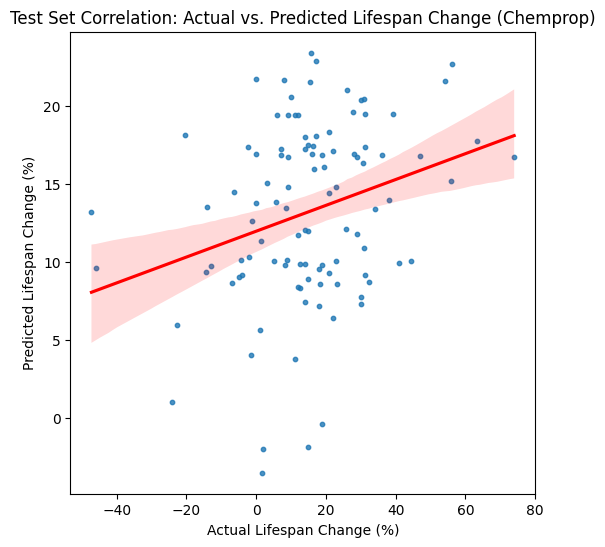

In [23]:
plt.figure(figsize=(6, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel("Actual Lifespan Change (%)")
plt.ylabel("Predicted Lifespan Change (%)")
plt.title("Test Set Correlation: Actual vs. Predicted Lifespan Change (Chemprop)")
plt.show()